<a href="https://colab.research.google.com/github/hkaragah/google_colab_repo/blob/main/hands_on_ml_exercises/06_simple_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree: Iris Dataset

__Disclaimer:__ This exercise is adopted from `"Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow (Third Edition)"` book written by `_Aurelien Geron_` publoshed by `_O'Reilly_`. I broke them down into smaller digestable snippets, made some modifications, and added some explanations so that I can undersatand them better. The porpuse of this notebook is just for me to understand the concept and have hands-on practice while reading the book material.

## Objective
Apply decision tree method to _iris_ dataset

## Load Dataset

In [1]:
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from graphviz import Source
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [2]:
iris = load_iris()
data = iris.data
target = iris.target
print(f"Feature shape: {data.shape}\nFeature names: {iris.feature_names}\n")
print(f"Target shape: {target.shape}\nTarget names: {iris.target_names}")

Feature shape: (150, 4)
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Target shape: (150,)
Target names: ['setosa' 'versicolor' 'virginica']


## Create Input and Output  Matrices

In [3]:
# Use only two feature for this exercise
X_train = data[:, 2:] # 3rd and 4th columns correspond to 'petal length (cm)' and 'petal width (cm)'
y_train = target # there are 3 classes 0, 1, 2

## Define and Train Model

In [4]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

## Visualize Tree

In [5]:
def plot_tree(tree_clf):
    # Create and export .dot file
    export_graphviz(
            tree_clf,
            out_file= 'file.dot',
            feature_names=iris.feature_names[2:],
            class_names=iris.target_names,
            rounded=True,
            filled=True)

    # Display .dot file
    return Source.from_file('file.dot')

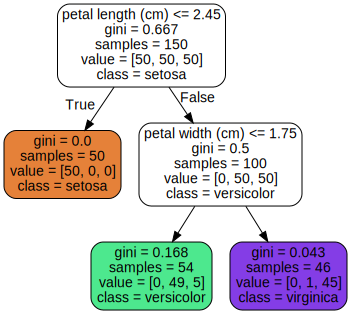

In [6]:
plot_tree(tree_clf)


## Gini Attribute
Gini attribute at node _i_, denoted as $G_i$, indicates the impurity of that node:

* 100% pure → gini=0
* 100% impure → gini=1

Here is how it is computed:

$$G_i = 1- \sum_{k=1}^{n}{p^2_{i,k}}$$

where $p_{i,k}$ is the ratio of the number of class $k$ instances to the total number of training instances in the $i^{th}$ node.



In [7]:
tree = tree_clf.tree_

for i in range(tree.node_count):
  if tree.children_left[i] == tree.children_right[i]:
    print(f"Node {i} is a leaf node")
  else:
    print(f"Node {i} is not a leaf node")

  print(f"Gini impurity: {tree.impurity[i]:.3f}")
  print(f"Samples: {tree.n_node_samples[i]}")
  print(f"Value: {tree.value[i]}\n")

Node 0 is not a leaf node
Gini impurity: 0.667
Samples: 150
Value: [[50. 50. 50.]]

Node 1 is a leaf node
Gini impurity: 0.000
Samples: 50
Value: [[50.  0.  0.]]

Node 2 is not a leaf node
Gini impurity: 0.500
Samples: 100
Value: [[ 0. 50. 50.]]

Node 3 is a leaf node
Gini impurity: 0.168
Samples: 54
Value: [[ 0. 49.  5.]]

Node 4 is a leaf node
Gini impurity: 0.043
Samples: 46
Value: [[ 0.  1. 45.]]



Let's manually compute the __Gini__ at the left node located at depth 2.

In [8]:
# Number of samples at this node
index = 3

samples = tree.n_node_samples[index] # 54
values = tree.value[index] # [[ 0. 49.  5.]]

gini = 1 - np.sum(np.square(values/samples))

print(f"Gini impurity: {gini:.3f}")

Gini impurity: 0.168


## Train Deeper Tree

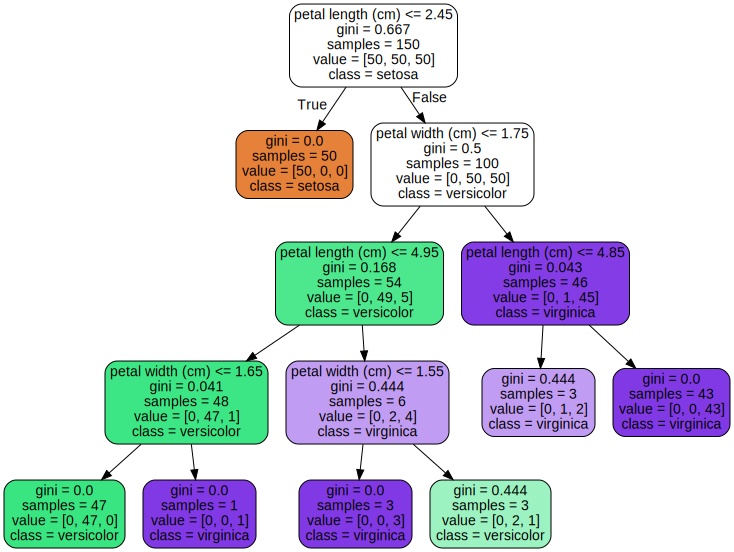

In [9]:
tree_clf1 = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf1.fit(X_train, y_train)

plot_tree(tree_clf1)

## Estimate Class Probability

In [10]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [11]:
tree_clf.predict([[5, 1.5]]) # Class 1 corresponds to "Versicolor"

array([1])

In [12]:
# Compute probablities manually
index = 3
setosa_proba = tree.value[index, 0, 0]/tree.n_node_samples[index]
versicolor_proba = tree.value[index, 0, 1]/tree.n_node_samples[index]
virginica_proba = tree.value[index, 0, 2]/tree.n_node_samples[index]
print(f"Setosa: {setosa_proba:.3f}\nVersicolor: {versicolor_proba:.3f}\nVirginica: {virginica_proba:.3f}")

Setosa: 0.000
Versicolor: 0.907
Virginica: 0.093


In [13]:
np.argmax([setosa_proba, versicolor_proba, virginica_proba]) # Class 1 corresponds to "Versicolor"

1

## Entropy vs. Gini
I create and train another classifier using `criterion='entropy'`.

In [14]:
tree_clf2 = DecisionTreeClassifier(max_depth=2, criterion='entropy', random_state=42)
tree_clf2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)

Let see what we have.

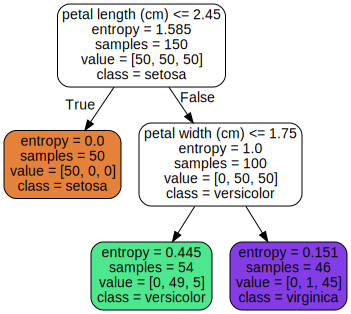

In [15]:
# Create and export .dot file
plot_tree(tree_clf2)

The leaf nodes are identical with the same number of samples, value, and classifications. Let's compute the entropy manually.

In [16]:
tree2 = tree_clf2.tree_

samples2 = tree2.n_node_samples[index] # 54
values2 = tree2.value[index] # [[0 , 49, 5]]

log2 = np.log2(values2/samples2)
entropy = -np.sum((values2/samples2) * np.where(np.isinf(log2), 0, log2))
print(f"Entropy: {entropy:.3f}") # 0.445

Entropy: 0.445


<ipython-input-16-cb94daacbe26>:6: RuntimeWarning: divide by zero encountered in log2
  log2 = np.log2(values2/samples2)


## Axis Sensitivity


In [17]:
X_train.shape

(150, 2)

In [18]:
angle = np.pi / 6 # 30 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])

X_train_rot = X_train @ rotation_matrix # (150, 2) x (2, 2) = (150, 2)
tree_clf_rot = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_rot.fit(X_train_rot, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

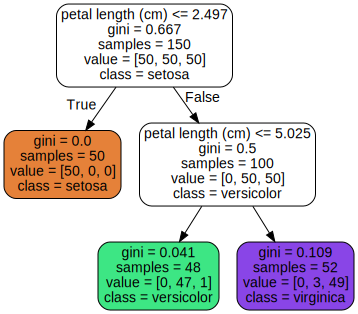

In [19]:
plot_tree(tree_clf_rot)

In [20]:
def generate_meshgrid(X, n):

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, n),
                         np.linspace(x2_min, x2_max, n))
    return x1, x2


def plot_decision_boundary(clf, X, y, ax, cmap):
    n = 100
    x1, x2 = generate_meshgrid(X, n) # x1 and x2 are of shape (n, n)

    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['#DEF9C4', '#9CDBA6', '#468585'])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap) # field
    ax.contour(x1, x2, y_pred, cmap="crest", linewidths=[0.5,0.5,0.5], alpha=0.8) # line


def plot_points(X, y, ax, styles, ax_labels):
    for i in range(len(styles)):
        ax.plot(X[:, 0][y==i], X[:, 1][y==i], styles[i], label=iris.target_names[i])

    ax.legend()
    ax.set_xlabel(ax_labels[0])
    ax.set_ylabel(ax_labels[1], rotation=0)

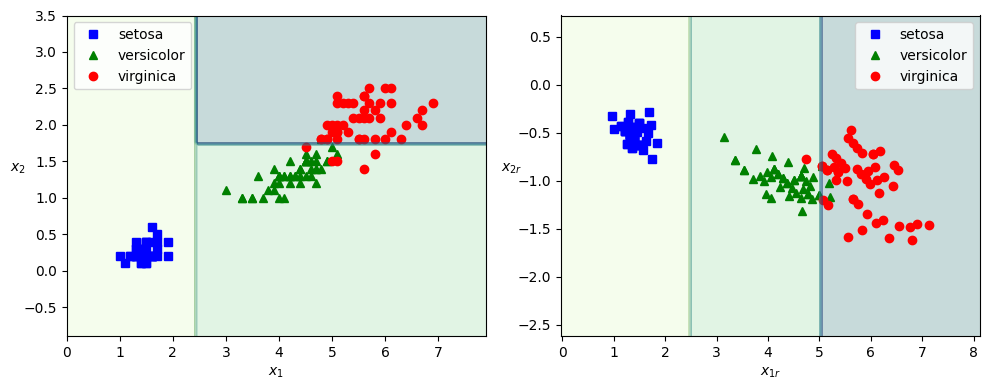

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))


plot_points(X_train, y_train, axes[0], ["bs", "g^", "ro"], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(tree_clf, X_train, y_train, axes[0],cmap="Pastel1")

plot_points(X_train_rot, y_train, axes[1], ["bs", "g^", "ro"], ax_labels=[r"$x_{1r}$", r"$x_{2r}$"])
plot_decision_boundary(tree_clf_rot, X_train_rot, y_train, axes[1], cmap="Pastel1")

plt.tight_layout()
plt.show()

Rotating the axes by 30 degrees made the decision purely based on the transformed petal length ($x_{1r}$). Looking at the _Gini_ values, there is also a slight imporvement. They reduced from 0.168 and 0.043 to 0.041 and 0.109 for 'versicolor' and 'virginica' respectively. This shows the sensitivity of the decision tree to axis orientation.<br>
A method to reduce this sensitivity is to 'scale' the data and apply 'principal component analysis (PCA)'. Let see how it works.

In [22]:
transformation_pipeline = make_pipeline(StandardScaler(), PCA()) # PCA w/o n_component will keep all the component (no reduction)
X_train_transformed = transformation_pipeline.fit_transform(X_train)
tree_clf_transformed = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_transformed.fit(X_train_transformed, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

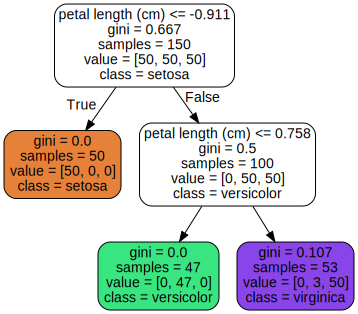

In [23]:
plot_tree(tree_clf_transformed)

The _Gini_ values are 0.0 at two leaves, _setosa_ and _versicolor_. Let's compare the decision boundaries.

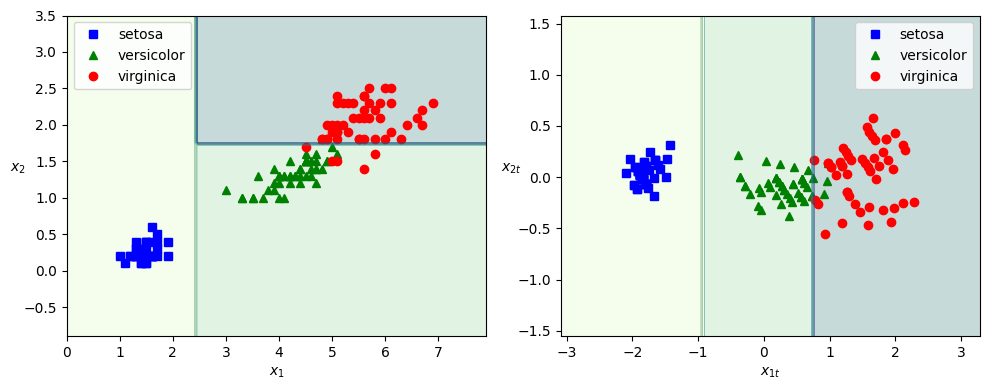

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))


plot_points(X_train, y_train, axes[0], ["bs", "g^", "ro"], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(tree_clf, X_train, y_train, axes[0],cmap="Pastel1")

plot_points(X_train_transformed, y_train, axes[1],["bs", "g^", "ro"], ax_labels=[r"$x_{1t}$", r"$x_{2t}$"])
plot_decision_boundary(tree_clf_transformed, X_train_transformed, y_train, axes[1], cmap="Pastel1")

plt.tight_layout()
plt.show()

This transformation have similar effect as the one that I obtained with rotating the axes 30 degrees. It seems the axes that I computed by 30-degree rotation is close to the principle components.<br>

## Decision Tree High Variance
If I train two decision trees with two different random states I would get two different boudnaries. This is because DecisionTreeClassifier has high variance, and small changes in hyper parameters or training data can lead into a totally different model.<br>


In [31]:
tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(random_state=1)

tree_clf1.fit(X_train, y_train)
tree_clf2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

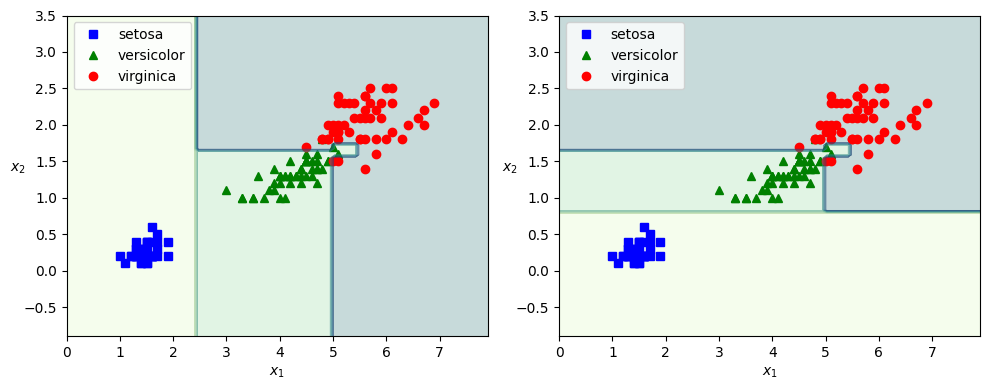

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))


plot_points(X_train, y_train, axes[0], ["bs", "g^", "ro"], ax_labels=[r"$x_1$", r"$x_2$"])
plot_decision_boundary(tree_clf1, X_train, y_train, axes[0],cmap="Pastel1")

plot_points(X_train, y_train, axes[1],["bs", "g^", "ro"], ax_labels=[r"$x_{1}$", r"$x_{2}$"])
plot_decision_boundary(tree_clf2, X_train, y_train, axes[1], cmap="Pastel1")

plt.tight_layout()
plt.show()

The train data is the same, but because the models have different hyperparameter, the boundaries are different.